In [32]:
import numpy as np
import pandas as pd
import collections
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn import metrics
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import graphviz
from graphviz import Source
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
%matplotlib inline

#### Auxiliary functions

In [33]:
def boldprint(text):
    print ('\033[1m'+text+'\033[0m')

In [34]:
def print_column_names(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df.iloc[0][:])

In [35]:
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    from lightgbm import LGBMClassifier
    
    from xgboost.core     import XGBoostError
    from lightgbm.sklearn import LightGBMError
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (XGBoostError, LightGBMError, ValueError):
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.barh(feat_imp.index.values, feat_imp.loc[:,'importance'])
    ax.set_xlabel('Feature Importance Score')
    ax.set_xlim(0,1)
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

## Load Dataset

In [36]:
DATASET_PATH= '../dataset/'
raw_import_df = {}

In [37]:
merged_df = pd.read_csv(DATASET_PATH + 'V2_train_df.csv', index_col=0, low_memory=False)
raw_import_df['merged'] = merged_df

## Prepare data

In [38]:
raw_import_df['merged'].drop(columns=[col for col in raw_import_df['merged'].columns if ('_Nº. Paciente' in col) or ('_Nº da Intervenção' in col)], inplace=True)

## Train Test Split

In [39]:
MINIMUM_SAMPLES = 10
skip_col = {}
skip_col['ADASYN'] = []
skip_col['RandomOverSampler'] = []
skip_col['SMOTE'] = []
skip_col['imbalanced'] = []

In [40]:
def split_train_valid(df, y_column, strategy):
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    #imp = imp.fit(df.iloc[:,:-1])
    x_df = df.filter(items=[col for col in df.columns if ('evolucao_' not in col)], axis=1)
    imp = imp.fit(x_df)

    # Impute our data, then train
    X_imp = pd.DataFrame(data= imp.transform(x_df), columns=x_df.columns, index= x_df.index)
    
    y_df = df.filter(items=[y_column], axis=1)
    
    X, X_valid, y, y_valid = train_test_split(X_imp, y_df, test_size=0.2, random_state=42)

    min_n_samples = np.min(y.iloc[:,0].value_counts())
    if (min_n_samples < MINIMUM_SAMPLES):
        skip_col[strategy].append(y_column)
        raise Exception('Bellow MINIMUM_SAMPLES ', y_column)
        
    if strategy == 'ADASYN':
        ovrsmp = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
        X_res, y_res = ovrsmp.fit_resample(X, y)
    elif strategy == 'RandomOverSampler':
        ovrsmp = RandomOverSampler(random_state=42)
        X_res, y_res = ovrsmp.fit_resample(X, y)
    elif strategy == 'SMOTE':
        ovrsmp = SMOTE(random_state=42, k_neighbors=5)
        X_res, y_res = ovrsmp.fit_resample(X, y)
    elif strategy == 'imbalanced':
        X_res = X
        y_res = y
    else:
        raise Exception('strategy %s not suported' % strategy)

    return {'X':X_res, 'X_valid': X_valid, 'y': y_res, 'y_valid': y_valid}

In [41]:
dataset = {}
for table in raw_import_df.keys():
    boldprint(table)
    strategies = ['ADASYN','SMOTE','RandomOverSampler','imbalanced']
    dataset[table] = {}
    for strategy in strategies:
        boldprint(strategy)
        y_columns = [col for col in raw_import_df[table].columns if ('evolucao_' in col)]
        dataset[table][strategy] = {}
        for col in y_columns:
            try:
                dataset[table][strategy][col] = split_train_valid(raw_import_df[table], col, strategy)
                print(col)
                print('training')
                print(dataset[table][strategy][col]['y'].iloc[:,0].value_counts())
                print('validation')
                print(dataset[table][strategy][col]['y_valid'].iloc[:,0].value_counts())

                if (dataset[table][strategy][col]['y'].iloc[:,0].value_counts().shape != (2,) or dataset[table][strategy][col]['y_valid'].iloc[:,0].value_counts().shape != (2,)):
                    print('Removing label ', col)
                    del dataset[table][strategy][col]
                    continue

                if (dataset[table][strategy][col]['y'].iloc[:,0].value_counts()[1] <= MINIMUM_SAMPLES or dataset[table][strategy][col]['y_valid'].iloc[:,0].value_counts()[1] <= MINIMUM_SAMPLES):
                    print('Removing label ', col)
                    del dataset[table][strategy][col]
                    continue
            except Exception as error:
                print('Skiping col ', col, error)
            print()
    #break

merged
ADASYN
evolucao_Problema Clínico
training
1    5963
0    5938
Name: evolucao_Problema Clínico, dtype: int64
validation
0    1481
1    64  
Name: evolucao_Problema Clínico, dtype: int64

evolucao_Infarto após Intervenção
training
1    6109
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
validation
0    1505
1    40  
Name: evolucao_Infarto após Intervenção, dtype: int64

evolucao_Óbito Hospitalar
training
0    6096
1    6074
Name: evolucao_Óbito Hospitalar, dtype: int64
validation
0    1534
1    11  
Name: evolucao_Óbito Hospitalar, dtype: int64

evolucao_Complicação Vascular
training
0    6152
1    6141
Name: evolucao_Complicação Vascular, dtype: int64
validation
0    1540
1    5   
Name: evolucao_Complicação Vascular, dtype: int64
Removing label  evolucao_Complicação Vascular
Skiping col  evolucao_I.R.A ('Bellow MINIMUM_SAMPLES ', 'evolucao_I.R.A')

Skiping col  evolucao_I.R.A Dialítica ('Bellow MINIMUM_SAMPLES ', 'evolucao_I.R.A Dialítica')

Skiping col  evoluc

In [43]:
skip_col

{'ADASYN': ['evolucao_I.R.A',
  'evolucao_I.R.A Dialítica',
  'evolucao_A.V.C Hemorrágico',
  'evolucao_A.V.C Isquêmico'],
 'RandomOverSampler': ['evolucao_I.R.A',
  'evolucao_I.R.A Dialítica',
  'evolucao_A.V.C Hemorrágico',
  'evolucao_A.V.C Isquêmico'],
 'SMOTE': ['evolucao_I.R.A',
  'evolucao_I.R.A Dialítica',
  'evolucao_A.V.C Hemorrágico',
  'evolucao_A.V.C Isquêmico'],
 'imbalanced': ['evolucao_I.R.A',
  'evolucao_I.R.A Dialítica',
  'evolucao_A.V.C Hemorrágico',
  'evolucao_A.V.C Isquêmico']}

In [44]:
#scale_pos_weight = count(negative examples)/count(Positive examples)
def get_scale_pos_weight(y):
    scale_pos_weight = 1
    if len(y.value_counts()) == 2:
        scale_pos_weight = y.value_counts()[0]/y.value_counts()[1]
    return scale_pos_weight

In [45]:
def calculate_tpr(model, X, y):
    if model == None:
        return
    
    tpr = 0
    predictions = model.predict(X)
    cm = metrics.confusion_matrix(y.values, predictions)
    if (cm.shape == (2,2)):
            tn, fp, fn, tp = cm.ravel()
            #true positive rate
            tpr = tp/(tp+fn)
    return tpr              
            
def predict(model, X, y, plot_importances=False):
    if model == None:
        return
    
    tpr = 0
    print('Value counts')
    print(y.value_counts())
    print('Score: ', model.score(X, y))
    predictions = model.predict(X)
    cm = metrics.confusion_matrix(y.values, predictions)
    if (cm.shape == (2,2)):
        tn, fp, fn, tp = cm.ravel()
        print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)
        print(metrics.classification_report(y.values, predictions))
        #true positive rate
        if (tp+fn) > 0:
            tpr = tp/(tp+fn)
            print('True positive rate: ', tpr)
        if plot_importances and (tpr > 0.3):
            plot_feature_importances(model, X, y, top_n=10, print_table=False, title= y.name)
    else:
        print()
        print('Predictions could not be calculated')
        print()

In [24]:
#Class Balance Loss
# # Normalized weights based on inverse number of effective data per class.
# img_num_per_cls = data_utils.get_img_num_per_cls(
#   hparams['data_version'], hparams['imb_factor'])
# effective_num = 1.0 - np.power(hparams['beta'], img_num_per_cls)
# weights = (1.0 - hparams['beta']) / np.array(effective_num)
# weights = weights / np.sum(weights) * int(hparams['data_version'])

In [46]:
def fit_model(X, y, classifier="DecisionTree", params_grid={}):
    scoring = ['f1'] # ['balanced_accuracy', 'average_precision','f1']

    print('Fitting ', y.name, ' using ', classifier)
    if (y.value_counts().shape == (2,)):

        if classifier == "DecisionTree":
            model = tree.DecisionTreeClassifier()
        elif classifier == "XGBoost":
            model = XGBClassifier(random_state=42)
        elif classifier == "RandomForestClassifier":
            model = RandomForestClassifier()
        
        search = GridSearchCV(model, param_grid=params_grid, cv=5, verbose=0,scoring=scoring, refit="f1", n_jobs=1, return_train_score=True)
        search.fit(X,y)
        print('Best estimator', search.best_estimator_)
        return search.best_estimator_
    else:
        print('skipping model fit due to insufficient positive samples')
    
    return None

def train_models(dataset, params_grid={}):
    print("Training started...")
    classifiers = ["XGBoost", "DecisionTree", "RandomForestClassifier"]
    
    #tpr_results = {}
    dataset_models = {}
    for name in dataset.keys():
        print("dataset name ", name)
        #tpr_results[name] = {}
        dataset_models[name] = {}
        for strategy in dataset[name].keys():
            print("dataset strategy", strategy)
            df = dataset[name][strategy]
            labels = []
            models = {}
            for idx, label in enumerate(df.keys()):
                models_per_classifier ={}
                for classifier in classifiers:
                    bestmodel = fit_model(df[label]['X'], df[label]['y'].iloc[:,0], classifier, params_grid)
                    modelname = f'{name}_{strategy}_{label}_{classifier}'
                    pickle.dump(bestmodel, open(modelname + ".model", "wb"))
                    #tpr = calculate_tpr(bestmodel, df[label]['X_valid'], df[label]['y_valid'].iloc[:,0])
                    #labels.append((tpr, label))
                    models_per_classifier[classifier] = modelname
                models[label] = models_per_classifier   
                #tpr_results[name][strategy] = labels
                #break
            dataset_models[name][strategy] = models    
            #break
        #break

    print("Evaluations started...")
    for name in dataset.keys():
        boldprint("Dataset: " + name)
        for strategy in dataset[name].keys():
            print("strategy", strategy)
            df = dataset[name][strategy]
#             labels = tpr_results[name][strategy][classifier]
#             sorted_labels = sorted(labels, key=lambda x: x[0], reverse=True)
            for label in df.keys():
                #label = item[1]
                print("dataset label", label)
                for classifier in classifiers:
                    modelname = dataset_models[name][strategy][label][classifier]
                    file = open(modelname+'.model', 'rb')
                    bestmodel = pickle.load(file)
                    #bestmodel = fit_model(df['X'], df['y'][label], class_weight="balanced")
                    #pickle.dump(bestmodel, open(name + "_decision_tree_class_weight.model", "wb"))
                    #models[label] = bestmodel
                    print('Predictions for ', name + ' ' + label)
                    print('Predicting on traning...' + classifier)
                    predict(bestmodel, df[label]['X'], df[label]['y'].iloc[:,0])
                    print('Predicting on validation...' + classifier)
                    predict(bestmodel, df[label]['X_valid'], df[label]['y_valid'].iloc[:,0], True)
                    print()
                    #best_ccp_alpha(bestmodel, df[label]['X'], df[label]['y'].iloc[:,0], df[label]['X_valid'], df[label]['y_valid'].iloc[:,0])
                #break
            #break
        #break
    return dataset_models

In [47]:
dataset


KeyboardInterrupt: 

### Results

Training started...
dataset name  merged
dataset strategy ADASYN
Fitting  evolucao_Problema Clínico  using  XGBoost
Best estimator XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Fitting  evolucao_Problema Clínico  using  DecisionTree
Best estimator DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                   

Best estimator RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Fitting  evolucao_Óbito Hospitalar  using  XGBoost
Best estimator XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_est

Best estimator DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Fitting  evolucao_Problema Clínico  using  RandomForestClassifier
Best estimator RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, r

Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 6109
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00      6109

    accuracy                           1.00     12173
   macro avg       1.00      1.00      1.00     12173
weighted avg       1.00      1.00      1.00     12173

True positive rate:  1.0
Predicting on validation...XGBoost
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9728155339805825
tn: 1503 fp: 2 fn: 40 tp: 0
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1505
           1       0.00      0.00      0.00        40

    accuracy                           0.97      1545
   macro avg       0.49      0.50      0.49      1545
weighted avg       0.95      0.97      0.96      1545

True positive rate:  0.0

Predictions for  merged evolucao_Infarto após Intervenção
Predicting on tran

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6074
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6074

    accuracy                           1.00     12170
   macro avg       1.00      1.00      1.00     12170
weighted avg       1.00      1.00      1.00     12170

True positive rate:  1.0
Predicting on validation...XGBoost
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9883495145631068
tn: 1525 fp: 9 fn: 9 tp: 2
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.18      0.18      0.18        11

    accuracy                           0.99      1545
   macro avg       0.59      0.59      0.59      1545
weighted avg       0.99      0.99      0.99      1545

True positive rate:  0.18181818181818182

Predictions for  merged evolucao_Óbito Hospitalar
Predicting on trani

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1505
           1       0.10      0.10      0.10        40

    accuracy                           0.95      1545
   macro avg       0.54      0.54      0.54      1545
weighted avg       0.95      0.95      0.95      1545

True positive rate:  0.1

Predictions for  merged evolucao_Infarto após Intervenção
Predicting on traning...RandomForestClassifier
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 6064
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00      6064

    accuracy                           1.00     12128
   macro avg       1.00      1.00      1.00     12128
weighted avg       1.00      1.00      1.00     12128

True positive rate:  1.0
Predicting on validation...RandomForestClassifier
Value count

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

True positive rate:  1.0
Predicting on validation...XGBoost
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9889967637540453
tn: 1526 fp: 8 fn: 9 tp: 2
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.20      0.18      0.19        11

    accuracy                           0.99      1545
   macro avg       0.60      0.59      0.59      1545
weighted avg       0.99      0.99      0.99      1545

True positive rate:  0.18181818181818182

Predictions for  merged evolucao_Óbito Hospitalar
Predicting on trani

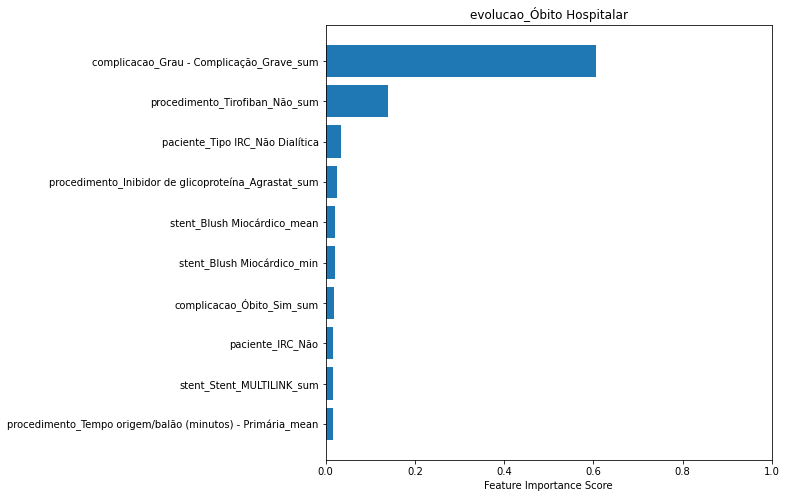


Predictions for  merged evolucao_Óbito Hospitalar
Predicting on traning...RandomForestClassifier
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

True positive rate:  1.0
Predicting on validation...RandomForestClassifier
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9928802588996763
tn: 1532 fp: 2 fn: 9 tp: 2
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1534
           1       0.50      0.18      0.27        11

    accuracy                           0.99      1545
   macro avg       0.75     

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

True positive rate:  1.0
Predicting on validation...XGBoost
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9902912621359223
tn: 1525 fp: 9 fn: 6 tp: 5
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1534
           1       0.36      0.45      0.40        11

    accuracy                           0.99      1545
   macro avg       0.68      0.72      0.70      1545
weighted avg       0.99      0.99      0.99      1545

True positive rate:  0.45454545454545453


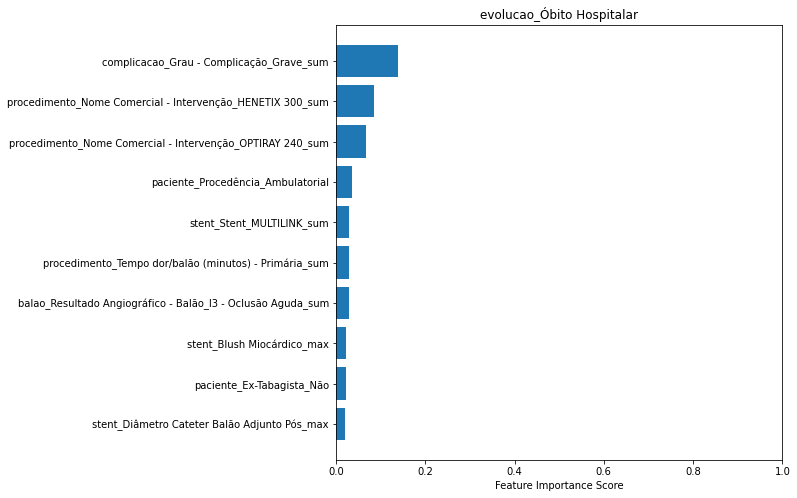


Predictions for  merged evolucao_Óbito Hospitalar
Predicting on traning...DecisionTree
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

True positive rate:  1.0
Predicting on validation...DecisionTree
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9915857605177993
tn: 1528 fp: 6 fn: 7 tp: 4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1534
           1       0.40      0.36      0.38        11

    accuracy                           0.99      1545
   macro avg       0.70      0.68      0.69     

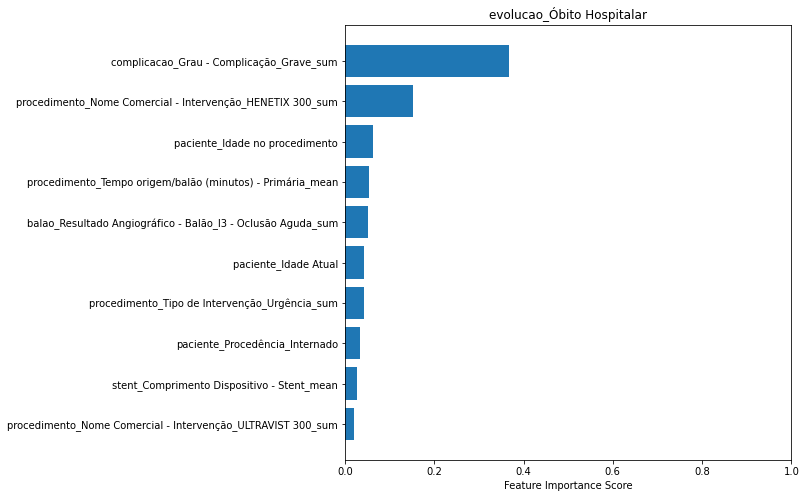


Predictions for  merged evolucao_Óbito Hospitalar
Predicting on traning...RandomForestClassifier
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

True positive rate:  1.0
Predicting on validation...RandomForestClassifier
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9909385113268608
tn: 1529 fp: 5 fn: 9 tp: 2
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1534
           1       0.29      0.18      0.22        11

    accuracy                           0.99      1545
   macro avg       0.64     

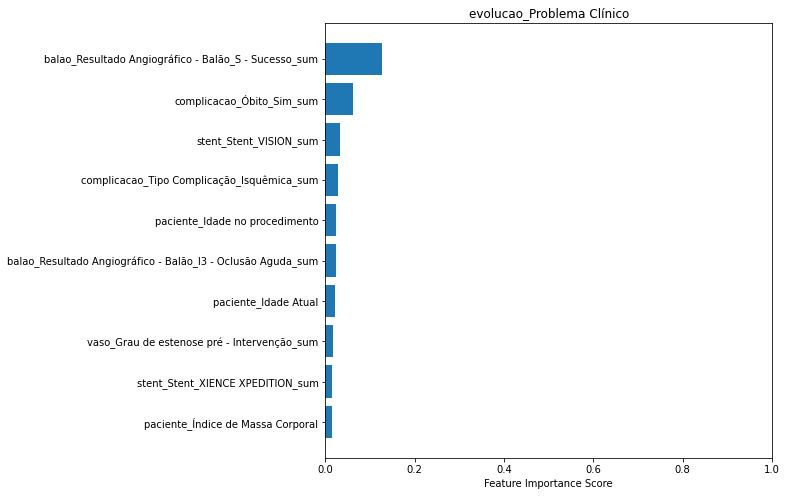


Predictions for  merged evolucao_Problema Clínico
Predicting on traning...RandomForestClassifier
Value counts
0    5938
1     240
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 240
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00       240

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...RandomForestClassifier
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9618122977346278
tn: 1478 fp: 3 fn: 56 tp: 8
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1481
           1       0.73      0.12      0.21        64

    accuracy                           0.96      1545
   macro avg       0.85     

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tn: 6096 fp: 0 fn: 0 tp: 82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00        82

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...XGBoost
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9902912621359223
tn: 1528 fp: 6 fn: 9 tp: 2
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1534
           1       0.25      0.18      0.21        11

    accuracy                           0.99      1545
   macro avg       0.62      0.59      0.60      1545
weighted avg       0.99      0.99      0.99      1545

True positive rate:  0.18181818181818182

Predictions for  merged evolucao_Óbito Hospitalar
Predicting on traning...DecisionT

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
trained_models = train_models(dataset)

In [27]:
def compute_metrics(y, true_y, index_label):
    
    # TPR = TP / P
#     if (debug):
#         y = x.values
#     else:
#         y = model.predict(x)
    
#     for idx, col in enumerate(true_y.columns):
#         print('col', col)
#         #pred = np.column_stack([y[:,idx], true_y[col]])
#         #print(pred)
#         tp = np.sum((y[:,idx]==1) & (true_y[col]==1))
#         p = np.sum(true_y[col]==1)
        
#         tn = np.sum((y[:,idx]==0) & (true_y[col]==0))
#         n = np.sum(true_y[col]==0)
        
#         fp = np.sum((y[:,idx]==1) & (true_y[col]==0))
        
#         fn = np.sum((y[:,idx]==0) & (true_y[col]==1))
#         #print(tn)
#         print('tp', tp, 'p', p, 'tpr', tp/p)
#         print('tn', tn, 'n', n, 'tpn', tn/n)
#         print('fp', fp, 'n', n, 'fpr', fp/n)
#         print('fn', fn, 'p', p, 'fnr', fn/p)
        
    #for idx, col in enumerate(true_y.columns):
    #print('col', col)
    #pred = np.column_stack([y[:,idx], true_y[col]])
    #print(pred)
    tp = np.sum((y==1) & (true_y==1), axis=0)
    p = np.sum(true_y==1, axis=0)
    tn = np.sum((y==0) & (true_y==0), axis=0)
    n = np.sum(true_y==0, axis=0)
    fp = np.sum((y==1) & (true_y==0), axis=0)
    fn = np.sum((y==0) & (true_y==1), axis=0)
    t = p + n
    tpr = tp/p
    tnr = tn/n
    fpr = fp/n
    fnr = fn/p
    acc = (tp + tn)/(p + n)
    ba  = (tpr + tnr)/2
    f1  = (2*tp) / (2*tp + fp + fn)
    ppv = tp / (tp + fp)
    #print(tn)
#     print('tp', tp, 'p', p, 'tpr', tp/p)
#     print('tn', tn, 'n', n, 'tnr', tn/n)
#     print('fp', fp, 'n', n, 'fpr', fp/n)
#     print('fn', fn, 'p', p, 'fnr', fn/p)
    cm = pd.DataFrame(np.array([t, p, n, ba, f1, ppv, tpr, tnr, fpr, fnr, acc]).reshape(1,11), \
                      index=[index_label], columns=['total', 'positives', 'negatives', 'balanced acc', 'F1', 'precision', 'recall tpr', 'tnr', 'fpr', 'fnr', 'acc'])
    cm = cm.round(2)
    #df = pd.concat(tpr, tnr, fpr, fnr)
    return cm

In [28]:
metrics_train = []
metrics_valid = []
for table in trained_models.keys():
    print(table)
    print(trained_models[table].keys())
    for strategy in trained_models[table].keys():
        print(strategy)
        print(trained_models[table][strategy].keys())
        for label in trained_models[table][strategy].keys():
            print(label)
            print(trained_models[table][strategy][label].keys())
            df = dataset[table][strategy][label]
            for classifier in trained_models[table][strategy][label].keys():
                print(classifier)
                modelname = trained_models[table][strategy][label][classifier]
                file = open(modelname+'.model', 'rb')
                model = pickle.load(file)
                
                x = df['X']
                y = model.predict(x)
                true_y = df['y']
                metrics_train.append(compute_metrics(y,true_y.to_numpy().flatten(), f"{table} {strategy} {label} {classifier}"))
                
                x = df['X_valid']
                y = model.predict(x)
                true_y = df['y_valid']
                metrics_valid.append(compute_metrics(y,true_y.to_numpy().flatten(), f"{table} {strategy} {label} {classifier}"))

merged
dict_keys(['ADASYN', 'SMOTE', 'RandomOverSampler', 'imbalanced'])
ADASYN
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar'])
evolucao_Problema Clínico
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier
evolucao_Infarto após Intervenção
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


evolucao_Óbito Hospitalar
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier
SMOTE
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar'])
evolucao_Problema Clínico
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier
evolucao_Infarto após Intervenção
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


evolucao_Óbito Hospitalar
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier
RandomOverSampler
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar'])
evolucao_Problema Clínico
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier
evolucao_Infarto após Intervenção
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


evolucao_Óbito Hospitalar
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier
imbalanced
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar'])
evolucao_Problema Clínico
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier
evolucao_Infarto após Intervenção
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


evolucao_Óbito Hospitalar
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier'])
XGBoost
DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


In [29]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [30]:
df_metrics_train = pd.concat(metrics_train)
df_metrics_train.to_csv("metrics_train.csv")
df_metrics_train

,total,positives,negatives,balanced acc,F1,precision,recall tpr,tnr,fpr,fnr,acc
merged ADASYN evolucao_Problema Clínico XGBoost,11901.0,5963.0,5938.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
merged ADASYN evolucao_Problema Clínico DecisionTree,11901.0,5963.0,5938.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
merged ADASYN evolucao_Problema Clínico RandomForestClassifier,11901.0,5963.0,5938.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
merged ADASYN evolucao_Infarto após Intervenção XGBoost,12173.0,6109.0,6064.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
merged ADASYN evolucao_Infarto após Intervenção DecisionTree,12173.0,6109.0,6064.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
merged ADASYN evolucao_Infarto após Intervenção RandomForestClassifier,12173.0,6109.0,6064.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
merged ADASYN evolucao_Óbito Hospitalar XGBoost,12170.0,6074.0,6096.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
merged ADASYN evolucao_Óbito Hospitalar DecisionTree,12170.0,6074.0,6096.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
merged ADASYN evolucao_Óbito Hospitalar RandomForestClassifier,12170.0,6074.0,6096.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
merged SMOTE evolucao_Problema Clínico XGBoost,11876.0,5938.0,5938.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [31]:
df_metrics_valid = pd.concat(metrics_valid)
df_metrics_valid.to_csv("metrics_valid.csv")
df_metrics_valid

,total,positives,negatives,balanced acc,F1,precision,recall tpr,tnr,fpr,fnr,acc
merged ADASYN evolucao_Problema Clínico XGBoost,1545.0,64.0,1481.0,0.58,0.27,0.65,0.17,1.00,0.00,0.83,0.96
merged ADASYN evolucao_Problema Clínico DecisionTree,1545.0,64.0,1481.0,0.61,0.25,0.24,0.27,0.96,0.04,0.73,0.93
merged ADASYN evolucao_Problema Clínico RandomForestClassifier,1545.0,64.0,1481.0,0.55,0.19,0.78,0.11,1.00,0.00,0.89,0.96
merged ADASYN evolucao_Infarto após Intervenção XGBoost,1545.0,40.0,1505.0,0.50,0.00,0.00,0.00,1.00,0.00,1.00,0.97
merged ADASYN evolucao_Infarto após Intervenção DecisionTree,1545.0,40.0,1505.0,0.58,0.20,0.23,0.18,0.98,0.02,0.82,0.96
merged ADASYN evolucao_Infarto após Intervenção RandomForestClassifier,1545.0,40.0,1505.0,0.50,0.00,NaN,0.00,1.00,0.00,1.00,0.97
merged ADASYN evolucao_Óbito Hospitalar XGBoost,1545.0,11.0,1534.0,0.59,0.18,0.18,0.18,0.99,0.01,0.82,0.99
merged ADASYN evolucao_Óbito Hospitalar DecisionTree,1545.0,11.0,1534.0,0.58,0.11,0.08,0.18,0.99,0.01,0.82,0.98
merged ADASYN evolucao_Óbito Hospitalar RandomForestClassifier,1545.0,11.0,1534.0,0.59,0.25,0.40,0.18,1.00,0.00,0.82,0.99
merged SMOTE evolucao_Problema Clínico XGBoost,1545.0,64.0,1481.0,0.59,0.28,0.57,0.19,0.99,0.01,0.81,0.96
